In [1]:
from cirq_sic import *
import recirq

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default") 

from IPython.display import display, Math, Markdown

In [2]:
experiment_name = "sky_ground"
base_dir = f"../experiments/data/{experiment_name}"

d = 2
flag = "numerical_sic"
n_shots_list = [1000, 5000, 10000, 20000, 50000, 100000]
keys = [("noisy", "ak"), ("noisy", "simple"), ("clean", "ak"), ("clean", "simple")]
all_metrics = process_sky_ground_data(d, flag, n_shots_list=n_shots_list, base_dir=base_dir)

# Metrics as a function of n_shots

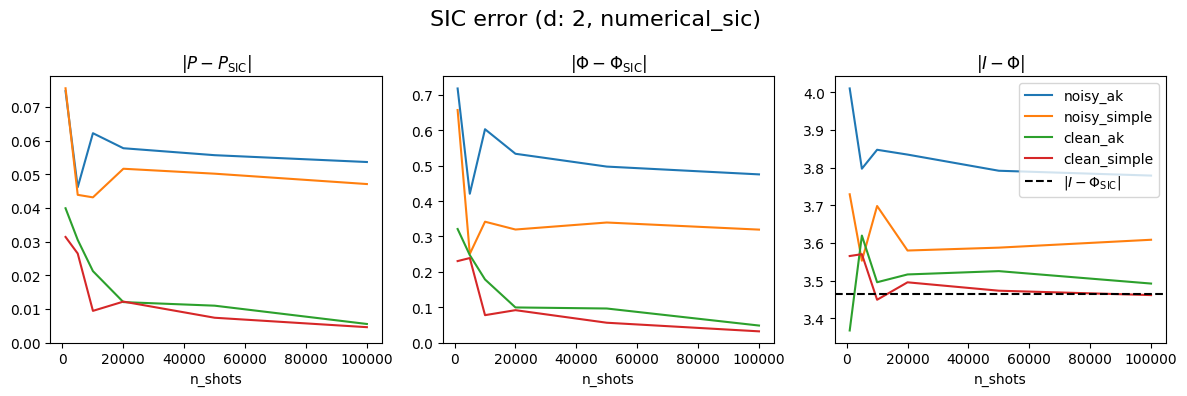

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for key in keys:
    axes[0].plot(n_shots_list, [all_metrics[key][n_shots]["P_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [all_metrics[key][n_shots]["Phi_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[2].plot(n_shots_list, [all_metrics[key][n_shots]["quantumness"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$|P - P_{\text{SIC}}|$")
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("n_shots")

axes[1].set_title(r"$|\Phi - \Phi_{\text{SIC}}|$")
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("n_shots")

axes[2].set_title(r"$|I - \Phi|$")
axes[2].axhline(np.linalg.norm(np.eye(d**2) - np.linalg.inv(SIC_P(d))), color='black', linestyle='--', label=r"$|I - \Phi_{\text{SIC}}|$")
axes[2].set_xlabel("n_shots")
axes[2].legend()

fig.suptitle("SIC error (d: %d, %s)" %  (d, flag), fontsize=16)
plt.tight_layout()
fig.savefig("img/sic_metrics_d%d_%s.pdf" % (d, flag), bbox_inches='tight')
plt.show()

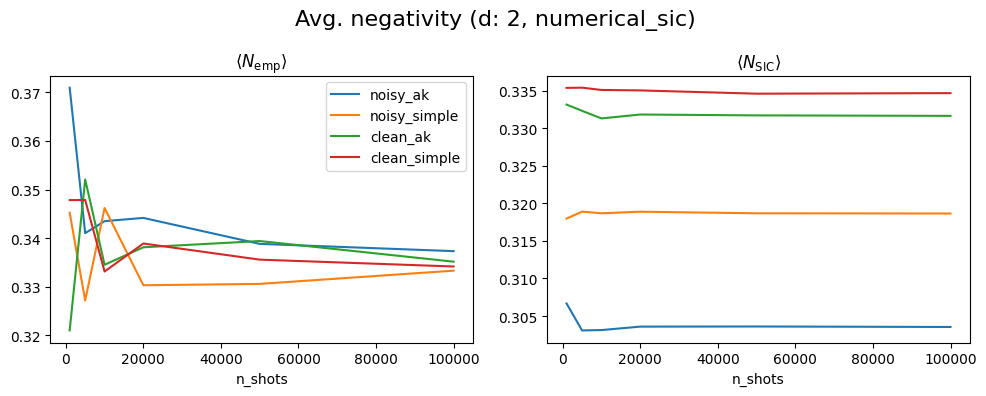

In [14]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for key in keys:
    axes[0].plot(n_shots_list, [all_metrics[key][n_shots]["neg_emp"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [all_metrics[key][n_shots]["neg_sic"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$\langle N_{\text{emp}}\rangle$")
axes[0].set_xlabel("n_shots")
axes[0].legend() 

axes[1].set_title(r"$\langle N_{\text{SIC}}\rangle$")
axes[1].set_xlabel("n_shots")

fig.suptitle("Avg. negativity (d: %d, %s)" %  (d, flag), fontsize=16)
plt.tight_layout()
fig.savefig("img/avg_neg_d%d_%s.pdf" % (d, flag), bbox_inches='tight')
plt.show()

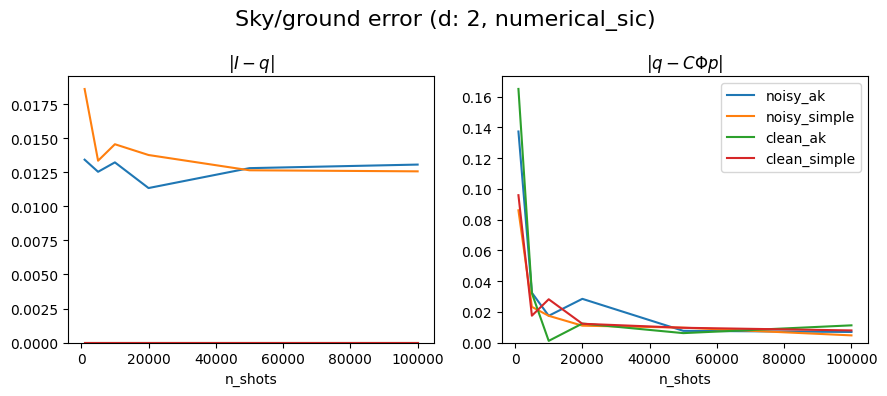

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for key in keys:
    axes[0].plot(n_shots_list, [all_metrics[key][n_shots]["q_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [all_metrics[key][n_shots]["sg_q_err"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$|I - q|$")
axes[0].set_xlabel("n_shots")
axes[0].set_ylim(bottom=0)

axes[1].set_title(r"$|q - C \Phi p|$")
axes[1].set_xlabel("n_shots")
axes[1].set_ylim(bottom=0)
axes[1].legend()

fig.suptitle("Sky/ground error (d: %d, %s)" %  (d, flag), fontsize=16)
plt.tight_layout()
fig.savefig("img/sg_metrics_d%d_%s.pdf" % (d, flag), bbox_inches='tight')
plt.show()

### Drilling down

In [28]:
experiment_name = "sky_ground"
base_dir = f'../experiments/data/{experiment_name}'

query = {"dataset_id": "d2",
         "d": 2,
         "processor_id": "willow_pink",
         "run_type": "clean",
         "wh_implementation": "simple",
         "n_shots": 100000,
         "flag": "numerical_sic"}
records = recirq.load_records(dataset_id=query["dataset_id"], base_dir=base_dir)

results = {}
for program, data_label in sky_ground_programs:
    results.update(program.process_results(query_records(records, {**query, "description": program.__name__})[0], n_shots=2001))
globals().update(results)
globals().update(calculate_sky_ground_metrics(P, p, C, q, verbose=True))

context_str = "d: %d, %s, %s, %s, n_shots: %d" % \
                    (query["d"], query["flag"], query["run_type"],\
                     query["wh_implementation"], query["n_shots"])

Sky/Ground Metrics:
|P - P_SIC| = 0.03399770385146417
|Phi - Phi_SIC| = 0.259330292869493
|I - Phi| = 3.372666075012887
|I - Phi_SIC| = 3.4641016151377544
|I - q| = 0.0
|q - C Phi p| = 0.02627344279270356


## $P$ vs $P_{\text{SIC}}$

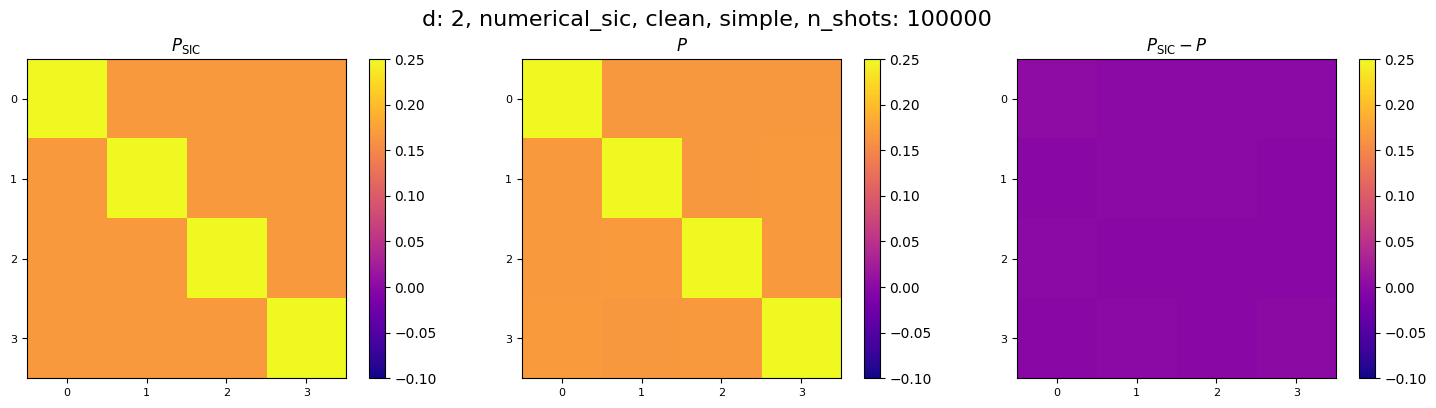

In [14]:
P_sic = SIC_P(query["d"])
n = query["d"]**2
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, mat, title in zip(axes, [P_sic, P, P_sic-P], [r'$P_{\text{SIC}}$', r'$P$', r'$P_{\text{SIC}}-P$']):
    im = ax.imshow(mat, cmap='plasma', extent=[-0.5, n-1/2, n-1/2, -0.5], vmin=-0.1, vmax=1/4)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_yticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='')
fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/P_d%d_%s_%s_%s_n%d.pdf" % (query["d"], query["flag"], query["run_type"],\
                                            query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()

## $q$ vs $C\Phi p$

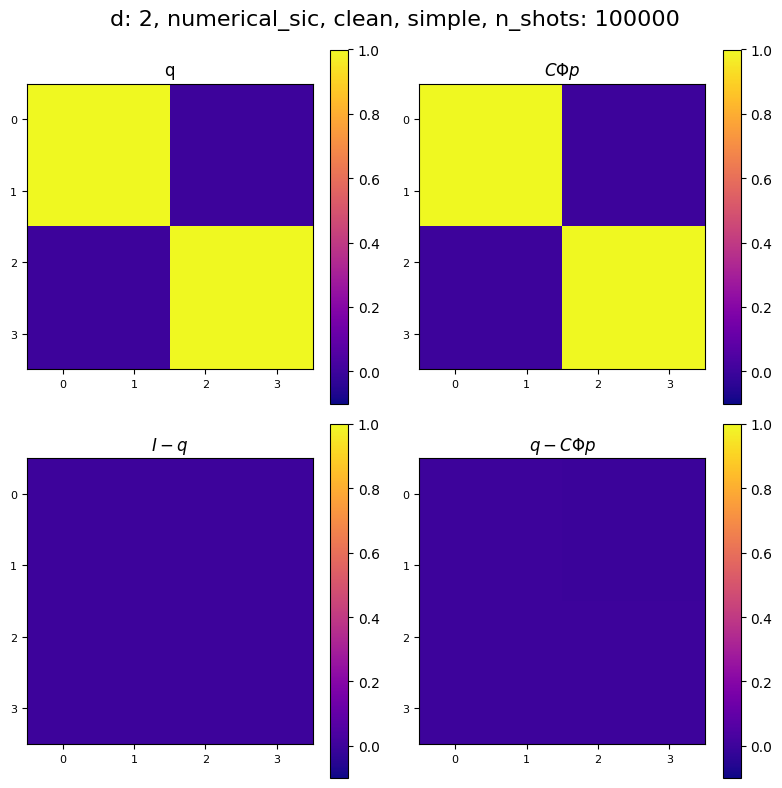

In [15]:
Phi = np.linalg.inv(P)
q_ = C @ Phi @ p

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
n = query["d"]**2
for ax, mat, title in zip(axes, [q, q_, np.eye(query["d"]) - q, q - q_], ['q', r'$C\Phi p$', r"$I-q$", r'$q - C\Phi p$']):
    im = ax.imshow(mat, cmap='plasma', extent=[-0.5, n-1/2, n-1/2, -0.5],  vmin=-0.1, vmax=1)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_yticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='')
fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/q_d%d_%s_%s_%s_n%d.pdf" % (query["d"], query["flag"], query["run_type"],\
                                            query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()